<a href="https://colab.research.google.com/github/doremon020848/stat-2/blob/main/%E0%B8%AA%E0%B8%B3%E0%B9%80%E0%B8%99%E0%B8%B2%E0%B8%82%E0%B8%AD%E0%B8%87_Lab11_Fine_Tuning_Reasoning_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Statistical Learning for Data Science 2 (229352)
#### Instructor: Donlapark Ponnoprat

#### [Course website](https://donlapark.pages.dev/229352/)

## Lab #10

# Fine-Tuning Qwen3 for Thai Text Reasoning

Today, you will learn how to take a pre-trained Large Language Model (LLM) and specialize it for **Thai text reasoning** using the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT).

We will be using [**Unsloth**](https://docs.unsloth.ai/get-started/all-our-models) to speeds up finetuning and reduces memory usage, making it possible to train in Google Colab.

If GPUs are not available in your Colab, you might want to try these two alternatives:
1. [Kaggle](https://www.kaggle.com)
2. [lightning.ai](https://lightning.ai)

### Installation

In [1]:
%%capture
import os
!pip install --upgrade -qqq uv
try: import numpy, PIL; _numpy = f'numpy=={numpy.__version__}'; _pil = f'pillow=={PIL.__version__}'
except: _numpy = "numpy"; _pil = "pillow"
try: import subprocess; is_t4 = "Tesla T4" in str(subprocess.check_output(["nvidia-smi"]))
except: is_t4 = False
_vllm, _triton = ('vllm==0.9.2', 'triton==3.2.0') if is_t4 else ('vllm==0.15.1', 'triton')
!uv pip install -qqq --upgrade {_vllm} {_numpy} {_pil} torchvision bitsandbytes xformers unsloth
!uv pip install -qqq {_triton}
!uv pip install transformers==4.56.2
!uv pip install --no-deps trl==0.22.2

### Fine-tuning Qwen3 with Unsloth

#### Transformer in Qwen3 vs GPT-2
<img src="https://substackcdn.com/image/fetch/$s_!GGk9!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2Fa8fa602a-aa4d-4526-9252-c2f09dd5de92_1871x1920.png" alt="transformers" width="600"/>

[Source: [Sebastian Raschka](https://magazine.sebastianraschka.com/p/qwen3-from-scratch)]

In [ ]:
from unsloth import FastLanguageModel
import torch

max_seq_length = 2048 # Can increase for longer reasoning traces
lora_rank = 32 # Larger rank = smarter, but slower

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Qwen3-14B",
    max_seq_length = max_seq_length,
    load_in_4bit = True, # False for LoRA 16bit
    fast_inference = False,
    max_lora_rank = lora_rank,
)

#### Low-Rank Adaptation (LoRA)
<img src="https://substackcdn.com/image/fetch/$s_!LXL5!,f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fsubstack-post-media.s3.amazonaws.com%2Fpublic%2Fimages%2F7ab94b67-4efa-45e2-9a77-3121d6c88c45_1284x364.png" alt="LoRA" width="600"/>

[Source: [Dasha Herrmannova](https://oneminutenlp.com/p/low-rank-adaptation)]

We now add LoRA adapters so we only need to update 1 to 10% of all parameters!

In [3]:
model = FastLanguageModel.get_peft_model(
    model,
    r = lora_rank, # Choose any number > 0 ! Suggested 8, 16, 32, 64, 128
    target_modules = [
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha = lora_rank*2, # *2 speeds up training
    use_gradient_checkpointing = "unsloth", # Reduces memory usage
    random_state = 3407,
)

Unsloth 2026.2.1 patched 40 layers with 40 QKV layers, 40 O layers and 40 MLP layers.


<a name="Data"></a>
### Data Prep
Use the [Thai Reasoning Dataset](https://huggingface.co/datasets/iapp/Thai-R1-Distill-SFT) provided by [iApp Technology](https://iapp.co.th/).

In [ ]:
from datasets import load_dataset
reasoning_dataset = load_dataset("iapp/Thai-R1-Distill-SFT", split = "train")

Let's see the structure of both datasets:

In [5]:
reasoning_dataset

Dataset({
    features: ['reannotated_assistant_content', 'problem', 'solution', 'id', 'source', 'verified', 'quality_metrics'],
    num_rows: 10000
})

We now convert the reasoning dataset into conversational format:

In [ ]:
from datasets import Dataset

def generate_conversation(examples):
    problems  = examples["problem"]
    solutions = examples["reannotated_assistant_content"]
    conversations = []
    for problem, solution in zip(problems, solutions):
        conversations.append([
            {"role" : "user",      "content" : problem},
            {"role" : "assistant", "content" : solution},
        ])
    return { "conversations": conversations, }

prepared_dataset = reasoning_dataset.to_pandas()
prepared_dataset["text"] = tokenizer.apply_chat_template(
    list(reasoning_dataset.map(generate_conversation, batched = True)["conversations"]),
    tokenize = False,
)
prepared_dataset = Dataset.from_pandas(prepared_dataset)

Let's see the first transformed row:

In [7]:
print(prepared_dataset[0]['text'])

<|im_start|>user
มีเด็กชาย 27 คนและเด็กหญิง 35 คนอยู่ในสนามเด็กเล่นในช่วงพัก มีเด็ก _____ คนอยู่ในสนามเด็กเล่นในช่วงพัก<|im_end|>
<|im_start|>assistant
<think>
ก่อนอื่น ฉันต้องคำนวณจำนวนเด็กทั้งหมดในสนามเด็กเล่นโดยนำจำนวนเด็กชายและเด็กหญิงมาบวกกัน มีเด็กชาย 27 คนและเด็กหญิง 35 คน เมื่อบวกกันแล้ว เด็กชาย 27 คน + เด็กหญิง 35 คน = เด็ก 62 คน ดังนั้น จำนวนเด็กทั้งหมดในสนามเด็กเล่นคือ 62 คน
</think>

 ในการหาจำนวนเด็กทั้งหมดในสนามเด็กเล่น เราเพียงแค่บวกจำนวนเด็กชายและเด็กหญิงเข้าด้วยกัน \[ \text{จำนวนเด็กทั้งหมด} = \text{จำนวนเด็กชาย} + \text{จำนวนเด็กหญิง} \] แทนค่าที่กำหนด: \[ \text{จำนวนเด็กทั้งหมด} = 27 \text{ เด็กชาย} + 35 \text{ เด็กหญิง} = 62 \text{ เด็ก} \] **คำตอบสุดท้าย:** \[ \boxed{62} \]<|im_end|>



<a name="Train"></a>
### Train the model
Now let's train our model. We do 60 steps to speed things up, but you can set `num_train_epochs=1` for a full run, and turn off `max_steps=None`.

First, let's clear some memory.

In [8]:
import gc

try:
  del reasoning_dataset
except NameError:
  pass

# Force Python to clean up the deleted objects from CPU RAM
gc.collect()

# Empty the PyTorch CUDA cache
torch.cuda.empty_cache()

In [ ]:
from trl import SFTTrainer, SFTConfig
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = prepared_dataset,
    args = SFTConfig(
        dataset_text_field = "text",
        per_device_train_batch_size = 1,
        gradient_accumulation_steps = 4, # Use GA to mimic batch size!
        warmup_steps = 5,
        max_steps = 30,
        # num_train_epochs = 1, # Set this for 1 full training run.
        learning_rate = 2e-4, # Reduce to 2e-5 for long training runs
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.001,
        lr_scheduler_type = "linear",
        seed = 3407,
        report_to = "none",
    ),
)

Let's train the model! To resume a training run, set `trainer.train(resume_from_checkpoint = True)`

In [ ]:
trainer_stats = trainer.train()

<a name="Inference"></a>
### Inference
Let's run the model via Unsloth native inference! According to the `Qwen-3` team, the recommended settings for reasoning inference are `temperature = 0.6, top_p = 0.95, top_k = 20`

For normal chat based inference, `temperature = 0.7, top_p = 0.8, top_k = 20`

In [11]:
FastLanguageModel.for_inference(model)

messages = [
    {"role" : "user", "content" : "จงหาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5"}
]
text = tokenizer.apply_chat_template(
    messages,
    tokenize = False,
    add_generation_prompt = True, # Must add for generation
    enable_thinking = True, # Enable thinking
)

from transformers import TextStreamer
_ = model.generate(
    **tokenizer(text, return_tensors = "pt").to("cuda"),
    max_new_tokens = 1500, # Increase for longer outputs!
    temperature = 0.6, top_p = 0.95, top_k = 20, # For non thinking
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)

<think>
โอเค ฉันมีปัญหาที่ว่า "หาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 - y^2 = 5" ฉันพยายามคิดว่าจะทำอย่างไร ฉันรู้ว่า x^2 - y^2 สามารถแยกตัวประกอบได้เป็น (x - y)(x + y) ดังนั้น ฉันจึงเขียนสมการใหม่เป็น (x - y)(x + y) = 5 ตอนนี้ ฉันจำได้ว่า 5 เป็นจำนวนเฉพาะ ซึ่งหมายความว่ามีตัวประกอบเพียง 1, -1, 5 และ -5 ดังนั้น ฉันจึงพิจารณาคู่ตัวประกอบเหล่านี้ ฉันจะลองคู่ตัวประกอบแต่ละคู่และดูว่าจะได้ x และ y ค่าใด 1. ลองคู่ตัวประกอบ (1, 5): ถ้า x - y = 1 และ x + y = 5 ฉันสามารถแก้ระบบสมการนี้โดยการบวกสมการทั้งสอง: (x - y) + (x + y) = 1 + 5 2x = 6 ดังนั้น x = 3 แทนค่า x = 3 ลงใน x - y = 1: 3 - y = 1 ดังนั้น y = 2 ฉันได้ (x, y) = (3, 2) 2. ลองคู่ตัวประกอบ (-1, -5): ถ้า x - y = -1 และ x + y = -5 ฉันจะบวกสมการทั้งสอง: (x - y) + (x + y) = -1 + (-5) 2x = -6 ดังนั้น x = -3 แทนค่า x = -3 ลงใน x - y = -1: -3 - y = -1 ดังนั้น y = -2 ฉันได้ (x, y) = (-3, -2) 3. ลองคู่ตัวประกอบ (5, 1): ถ้า x - y = 5 และ x + y = 1 ฉันจะบวกสมการทั้งสอง: (x - y) + (x + y) = 5 + 1 2x = 6 ดังนั้น x = 3 แทนค่า x = 3 ลงใน x - y = 5: 3 - y 

### Exercise 1: Ask the model a challenging **math problem in Thai**. You may increase the value of `max_new_tokens` if the model's answer is too short. Does the model solve your problem correctly?

In [ ]:
### YOUR CODE HERE ###
FastLanguageModel.for_inference(model)

messages_ex1 = [
    {"role" : "user", "content" : "จงหาจำนวนเฉพาะ p ทั้งหมดที่ p+2 และ p+4 ก็เป็นจำนวนเฉพาะด้วย"}
]
text_ex1 = tokenizer.apply_chat_template(
    messages_ex1,
    tokenize = False,
    add_generation_prompt = True,
    enable_thinking = True,
)

from transformers import TextStreamer
print("Model's response to Exercise 1:")
_ = model.generate(
    **tokenizer(text_ex1, return_tensors = "pt").to("cuda"),
    max_new_tokens = 2000, # Increased tokens for a detailed answer
    temperature = 0.6, top_p = 0.95, top_k = 20,
    streamer = TextStreamer(tokenizer, skip_prompt = True),
)


**Answer to Exercise 1**

--โมเดลคำนวนถูกต้องโดย จำนวนเฉพาะ p ทั้งหมดที่ p+2 และ p+4 ก็เป็นจำนวนเฉพาะด้วย คือ 3

### Visualizing Attention

In [12]:
!wget -q https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf

import matplotlib as mpl
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np

# Add the font to Matplotlib's registry
fm.fontManager.addfont('thsarabunnew-webfont.ttf')

# Set it as the default font for all plots
mpl.rc('font', family='TH Sarabun New', size=14)

### Exercise 2: Fill in the ##TODO## part in the `visualize_attention()` function below to calculate the product between the query matrix `Q` and the key matrix `K`.

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

def rotate_half(x):
    """Rotates half the hidden dimensions of the input."""
    x1 = x[..., : x.shape[-1] // 2]
    x2 = x[..., x.shape[-1] // 2 :]
    return torch.cat((-x2, x1), dim=-1)

# Define a global dictionary to store the attention matrix
attention_viz_data = {}

def visualize_attention(model, tokenizer, prompt, layer_number):
    """
    Visualizes the QK^T attention matrix for a given prompt and layer,

    Args:
        model: The Unsloth Qwen3 14B model.
        tokenizer: The tokenizer for the model.
        prompt (str): The input text prompt.
        layer_number (int): The decoder layer number to visualize.
    """
    attention_viz_data.clear()

    attention_layer = model.base_model.model.model.layers[layer_number].self_attn
    original_forward = attention_layer.forward

    def new_forward(self, hidden_states, *args, **kwargs):
        """A new forward method to capture the QK^T matrix."""

        bsz, q_len, _ = hidden_states.size()

        # Project to Q, K
        Q_all_heads = self.q_proj(hidden_states)
        K_all_heads = self.k_proj(hidden_states)

        # Reshape for multi-head attention. Note the different head counts.
        Q_all_heads = Q_all_heads.view(bsz, q_len, self.config.num_attention_heads, self.head_dim).transpose(1, 2)
        K_all_heads = K_all_heads.view(bsz, q_len, self.config.num_key_value_heads, self.head_dim).transpose(1, 2)

        # Get rotary embeddings
        cos, sin = self.rotary_emb(K_all_heads, seq_len=q_len)

        # Apply rotary embeddings directly
        Q_all_heads = (Q_all_heads * cos) + (rotate_half(Q_all_heads) * sin)
        K_all_heads = (K_all_heads * cos) + (rotate_half(K_all_heads) * sin)

        # Repeat the key heads to match the number of query heads.
        num_key_value_groups = self.config.num_attention_heads // self.config.num_key_value_heads
        if num_key_value_groups > 1:
            K_all_heads = K_all_heads.repeat_interleave(num_key_value_groups, dim=1)

        # Now, the dimensions match for matrix multiplication:
        # Q_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]
        # K_all_heads: [1, 40, 29, 128] = [batch_size, num_heads, seq_len, head_dim]

        Q = Q_all_heads[0, 0]  # Queries of the first head
        K = K_all_heads[0, 0]  # Keys of the first head

        ####### TODO: CALCULATE Softmax(QK^T / √head_dim)          #######
        ####### When computing Softmax, normalize along each row.  #######
        # Calculate QK^T
        qk_logits = torch.matmul(Q, K.transpose(-1, -2)) / (self.head_dim ** 0.5)
        # Apply softmax along each row (last dimension)
        attention = F.softmax(qk_logits, dim=-1)
        ##################################################################

        # Store the matrix for visualization
        attention_viz_data['qk_t'] = attention.detach()

        # Call the original forward method
        return original_forward(hidden_states, *args, **kwargs)

    try:
        attention_layer.forward = new_forward.__get__(attention_layer, type(attention_layer))

        inputs = tokenizer(prompt, return_tensors="pt")
        input_ids = inputs.input_ids.to(model.device)

        with torch.no_grad():
            _ = model(input_ids)

    finally:
        attention_layer.forward = original_forward

    # Visualize the captured data
    if 'qk_t' in attention_viz_data:
        qk_matrix = attention_viz_data['qk_t'].cpu().float().numpy()

        tokens = []
        for tok_id in input_ids[0]:
            decoded = tokenizer.decode([tok_id])

            if not decoded.strip():
                decoded = tokenizer.convert_ids_to_tokens([tok_id])[0]

            decoded = decoded.replace('Ġ', ' ')
            tokens.append(decoded)

        plt.figure(figsize=(12, 10))
        im = plt.imshow(qk_matrix, cmap='viridis', interpolation='nearest')
        plt.colorbar(im, label='Attention Score (Logits)')
        plt.xticks(ticks=np.arange(len(tokens)), labels=tokens, rotation=90)
        plt.yticks(ticks=np.arange(len(tokens)), labels=tokens)
        plt.xlabel("Key Tokens")
        plt.ylabel("Query Tokens")
        plt.title(f"QK^T Matrix Visualization for Layer {layer_number}, Head 0")
        plt.tight_layout()
        plt.show()
    else:
        print(f"Failed to capture the QK^T matrix for layer {layer_number}.")

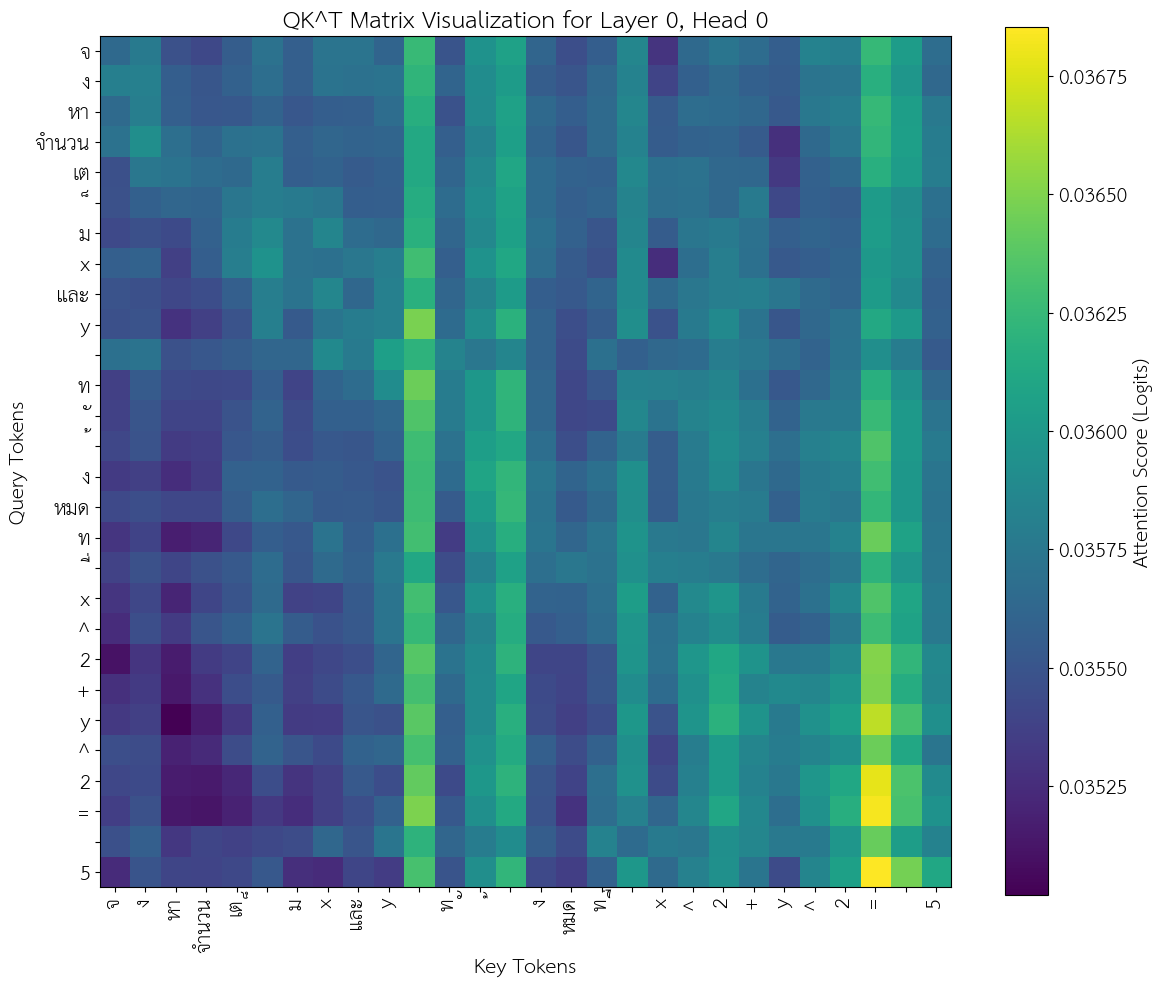

In [14]:
example_text = "จงหาจำนวนเต็ม x และ y ทั้งหมดที่ x^2 + y^2 = 5"

visualize_attention(model, tokenizer, example_text, 0)

### Exercise 3: Choose your own example of **math problem in Thai**. Find **two** pairs of two distinct words with the highest attention values. Why do you think those two pairs have the highest attention values?

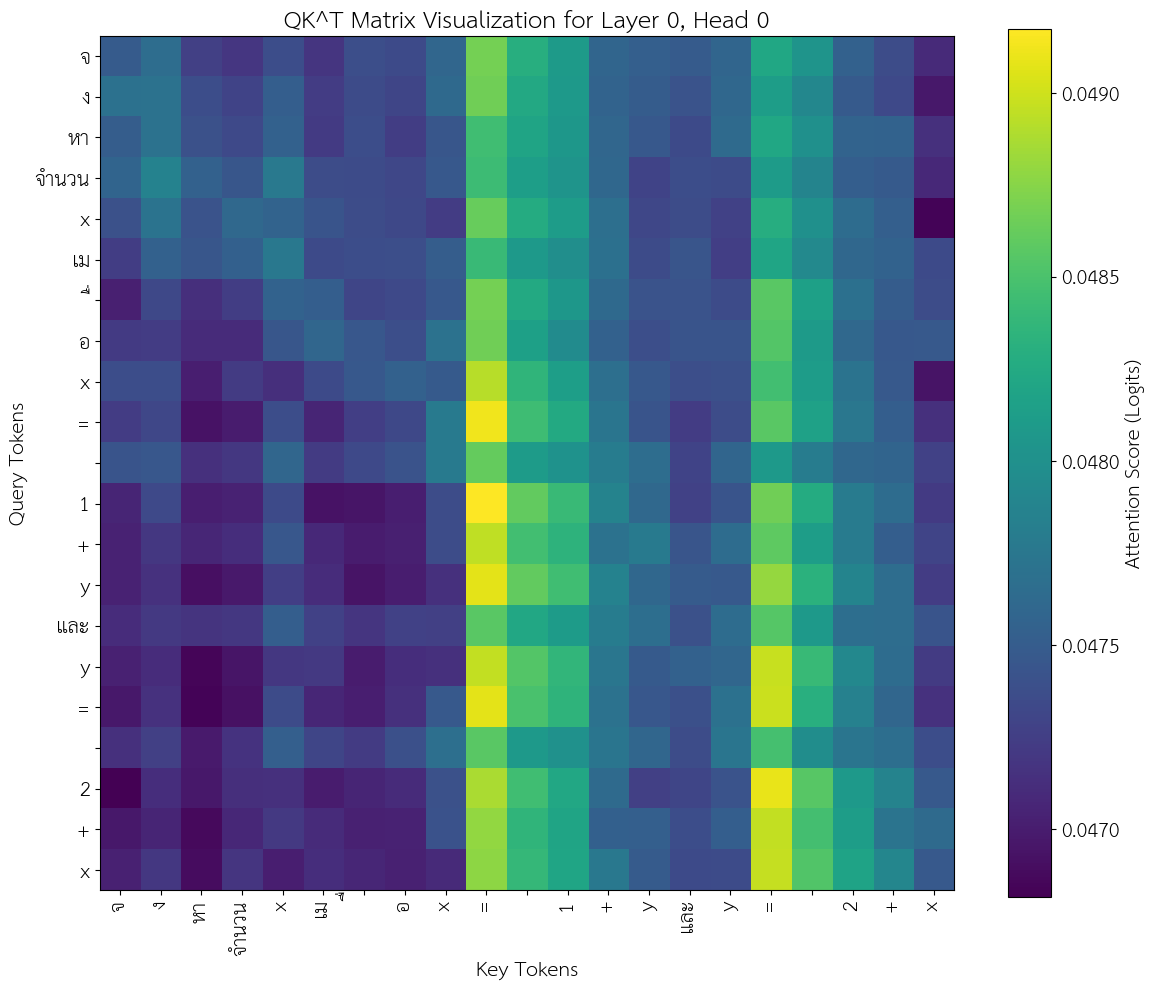

In [15]:
### YOUR CODE HERE ###

messages_ex2 = "จงหาจำนวน x เมื่อ x = 1 + y และ y = 2 + x"

visualize_attention(model, tokenizer, messages_ex2, 0)


**Answers to Exercise 3**

-จากตารางจะเห็นว่าคู่คำที่มี highest attention values คือ Query='1', Key=' =' with attention score = 0.0492 Query='2', Key=' =' with attention score = 0.0491

คู่ตัวเลขทั้งสองนี้แสดงค่าความสนใจสูงสุด เนื่องจากเป็นองค์ประกอบสำคัญในการกำหนดความสัมพันธ์ทางคณิตศาสตร์ภายในปัญหาที่กำหนด ในนิพจน์พีชคณิต เครื่องหมายเท่ากับ (=) เป็นพื้นฐานในการสร้างความสัมพันธ์หรือการกำหนดค่า ตัวเลข '1' และ '2'

<a name="Save"></a>
### Saving, loading finetuned models
To save the final model as LoRA adapters, either use Huggingface's `push_to_hub` for an online save or `save_pretrained` for a local save.

**[NOTE]** This ONLY saves the LoRA adapters, and not the full model. To save to 16bit or GGUF, scroll down!

In [16]:
model.save_pretrained("lora_model")  # Local saving
tokenizer.save_pretrained("lora_model")
# model.push_to_hub("your_name/lora_model", token = "...") # Online saving
# tokenizer.push_to_hub("your_name/lora_model", token = "...") # Online saving

('lora_model/tokenizer_config.json',
 'lora_model/special_tokens_map.json',
 'lora_model/chat_template.jinja',
 'lora_model/vocab.json',
 'lora_model/merges.txt',
 'lora_model/added_tokens.json',
 'lora_model/tokenizer.json')

Now if you want to load the LoRA adapters we just saved for inference, set `False` to `True`:

In [17]:
if False:
    from unsloth import FastLanguageModel
    model, tokenizer = FastLanguageModel.from_pretrained(
        model_name = "lora_model", # YOUR MODEL YOU USED FOR TRAINING
        max_seq_length = 2048,
        load_in_4bit = True,
    )

### Saving to float16 for VLLM

Unsloth also support saving to `float16` directly. Select `merged_16bit` for float16 or `merged_4bit` for int4. We also allow `lora` adapters as a fallback. Use `push_to_hub_merged` to upload to your Hugging Face account! You can go to https://huggingface.co/settings/tokens for your personal tokens.

In [18]:
# Merge to 16bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_16bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_16bit", token = "")

# Merge to 4bit
if False:
    model.save_pretrained_merged("model", tokenizer, save_method = "merged_4bit",)
if False: # Pushing to HF Hub
    model.push_to_hub_merged("hf/model", tokenizer, save_method = "merged_4bit", token = "")

# Just LoRA adapters
if False:
    model.save_pretrained("model")
    tokenizer.save_pretrained("model")
if False: # Pushing to HF Hub
    model.push_to_hub("hf/model", token = "")
    tokenizer.push_to_hub("hf/model", token = "")
